# Model Building

### Importiere Bibliotheken

In [39]:
import pandas as pd
import numpy as np

# region sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#endregion

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV

### Datensatz einlesen
Da Pandas die Datentypen der Merkmale nicht optimal erkennt, werden im Folgenden die konkreten Datentypen definiert. \
Diese können aus der Beschreibung des Datensatztes abgeleitet werden.

In [40]:
dtypes = {
    'Air temperature [K]': 'float32',
    'Process temperature [K]': 'float32',
    'Rotational speed [rpm]': 'float32',
    'Torque [Nm]': 'float32',
    'Tool wear [min]': 'float32',
    'Type_H': 'bool',
    'Type_L': 'bool',
    'Type_M': 'bool',
    'label': 'category'
}

df_train_resampled = pd.read_csv('./dataset_train_resampled.csv', dtype=dtypes)
df_test = pd.read_csv('./dataset_test.csv', dtype=dtypes)

### Definiere die Input- und Output- Merkmale

In [41]:
input_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_H', 'Type_L', 'Type_M']
output_column = ['label']

X_train = df_train_resampled[input_columns]
X_test = df_test[input_columns]
y_train = df_train_resampled[output_column].to_numpy().ravel()
y_test = df_test[output_column].to_numpy().ravel()

### Extrahiere Ziel-Klassen

In [42]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
unique_classes_str = label_encoder.classes_
unique_classes_int = list(range(len(unique_classes_str)))

### Trainiere die Modelle 

In [43]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

In [44]:
results = {}
for i, (model_name, model) in enumerate(models.items(), start=1):
    print(f'Model {i} of {len(models)}: {model_name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

results_df = pd.DataFrame(results).T
results_df

Model 1 of 5: Logistic Regression
Model 2 of 5: Random Forest
Model 3 of 5: Decision Tree
Model 4 of 5: Support Vector Machine
Model 5 of 5: K-Nearest Neighbors


,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.7915,0.973379,0.7915,0.866411
Random Forest,0.9610,0.972440,0.9610,0.966449
Decision Tree,0.9480,0.975003,0.9480,0.960870
Support Vector Machine,0.8535,0.971734,0.8535,0.905161
K-Nearest Neighbors,0.9105,0.963806,0.9105,0.934648


<font color='lightgreen'>Das RandomForest-Model besitzt den besten F1-Score</font>

### Hyperparameter-Tuning des RandomForest
Braucht ca. 15 min

In [45]:
parameter_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(),
    parameter_grid,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('accuracy ',  accuracy)
print('precision ', precision)
print('recall ',    recall)
print('f1 ',        f1)

accuracy  0.9605
precision  0.9712802590505119
recall  0.9605
f1  0.9656304198528927


In [46]:
y_test_bin = label_binarize(y_test, classes=unique_classes_str)
n_classes = y_test_bin.shape[1]

y_prob = model.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    if np.any(y_test_bin[:, i]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


fig = go.Figure()

for i in range(n_classes):
    if i in roc_auc:
        fig.add_trace(go.Scatter(
            x=fpr[i], 
            y=tpr[i], 
            mode='lines', 
            name=f'{unique_classes_str[i]} (AUC = {roc_auc[i]:.2f})'
        ))

fig.add_trace(go.Scatter(
    x=[0, 1], 
    y=[0, 1], 
    mode='lines', 
    line=dict(dash='dash'), 
    name='Random Guessing'
))

fig.update_layout(
    title="Receiver Operating Characteristic (ROC) Curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    xaxis=dict(scaleanchor="y", constrain="domain"),
    yaxis=dict(scaleanchor="x", constrain="domain"),
)

fig.show()

### Visualisiere die Feature-Importance

In [47]:
feature_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': models['Random Forest'].feature_importances_
}).sort_values(by='Importance', ascending=False)

fig = px.bar(
    feature_importances, x='Feature', y='Importance',
    title='Feature-Import des RandomForest',
    labels={'Importance': 'Relevanz', 'Feature': 'Merkmal'},
    text_auto=True
)

fig.show()

### Analysiere reduzierten Entscheidungsbaum

accuracy  0.8795
precision  0.9642543757381961
recall  0.8795
f1  0.9185531505491038


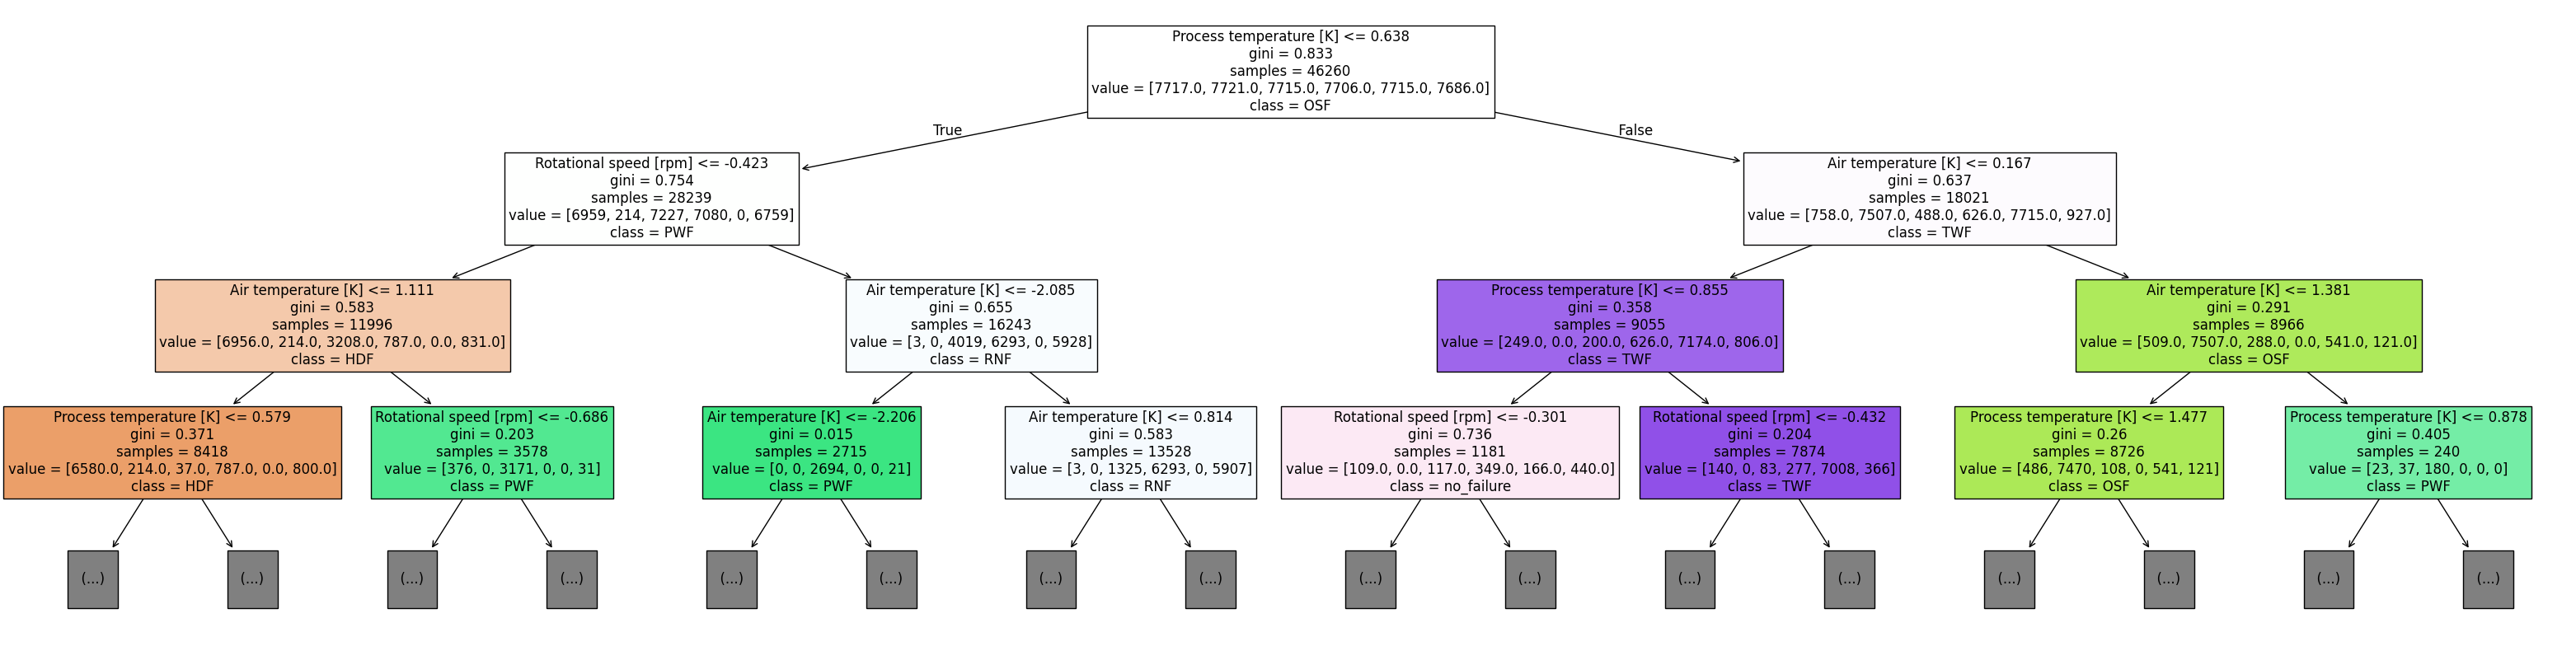

In [48]:
model = DecisionTreeClassifier()

most_relevant_features = ['Torque [Nm]', 'Tool wear [min]', 'Rotational speed [rpm]']

model.fit(X_train[most_relevant_features], y_train)
y_pred = model.predict(X_test[most_relevant_features])

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('accuracy ',  accuracy)
print('precision ', precision)
print('recall ',    recall)
print('f1 ',        f1)

plt.figure(figsize=(40, 10))
_ = plot_tree(
    model,
    max_depth=3,
    feature_names=X_test.columns,
    class_names=unique_classes_str,
    fontsize=12,
    filled=True
)